In [9]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import warnings
from collections import Counter
import datetime
import wordcloud
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import RFE
import json
import joblib
from sklearn.model_selection import GridSearchCV
import mlflow 

In [10]:
mlflow.set_tracking_uri("http://localhost:5000")

# Boston Housing Price Prediction Analysis

## Introduction
This notebook presents a comprehensive analysis of the Boston Housing dataset, which contains information about various features affecting housing prices in Boston suburbs. Our goal is to build and evaluate various machine learning models to predict housing prices based on these features.

### Dataset Overview
The dataset includes 13 features that might influence housing prices:
- Crime rate
- Residential land zoning
- Non-retail business acres proportion
- Charles River dummy variable
- Nitric oxides concentration
- Average number of rooms
- Age of properties
- Distance to employment centers
- Highway accessibility
- Property tax rate
- Pupil-teacher ratio
- Black population proportion
- Lower status population percentage

### Analysis Goals
1. Perform thorough Exploratory Data Analysis (EDA)
2. Engineer relevant features
3. Build and compare multiple prediction models
4. Identify the most important factors affecting house prices
5. Provide actionable insights for stakeholders

In [11]:
#  The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic
#  prices and the demand for clean air', J. Environ. Economics & Management,
#  vol.5, 81-102, 1978.   Used in Belsley, Kuh & Welsch, 'Regression diagnostics
#  ...', Wiley, 1980.   N.B. Various transformations are used in the table on
#  pages 244-261 of the latter.

#  Variables in order:
#  CRIM     per capita crime rate by town
#  ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
#  INDUS    proportion of non-retail business acres per town
#  CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
#  NOX      nitric oxides concentration (parts per 10 million)
#  RM       average number of rooms per dwelling
#  AGE      proportion of owner-occupied units built prior to 1940
#  DIS      weighted distances to five Boston employment centres
#  RAD      index of accessibility to radial highways
#  TAX      full-value property-tax rate per $10,000
#  PTRATIO  pupil-teacher ratio by town
#  B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
#  LSTAT    % lower status of the population
#  MEDV     Median value of owner-occupied homes in $1000's

# Define column names (original names)
columns = [
    "CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS",
    "RAD", "TAX", "PTRATIO", "B", "LSTAT", "MEDV"
]

# Store final rows here
rows = []

with open("boston_data.txt", "r") as file:
    lines = file.readlines()
    
    # Process every two lines
    for i in range(0, len(lines), 2):
        line1 = lines[i].strip().split()
        line2 = lines[i+1].strip().split()
        
        # Combine both halves into a full row of 14 values
        full_row = line1 + line2
        rows.append([float(val) for val in full_row])  # convert to float

# Create DataFrame
df = pd.DataFrame(rows, columns=columns)

# Save to CSV
df.to_csv("./datasets/raw_boston_housing.csv", index=False)

print("Conversion successful — Saved as boston_housing.csv")


Conversion successful — Saved as boston_housing.csv


## Data Preparation and Initial Exploration

In this section, we:
1. Load and preprocess the data
2. Rename columns for better readability
3. Perform initial data quality checks
4. Generate descriptive statistics

In [12]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [13]:
# Step 2: Friendly column names
friendly_columns = [
    "crime_rate", "residential_land_zone", "non_retail_land_pct", "near_charles_river",
    "nitric_oxide_conc", "avg_rooms_per_dwelling", "pct_pre_1940_units",
    "distance_to_employment", "highway_access_index", "property_tax_rate",
    "pupil_teacher_ratio", "black_residents_score", "lower_status_pct", "median_home_value_k"
]

for old_col, new_col in zip(df.columns, friendly_columns):
    df.rename(columns={old_col: new_col}, inplace=True)

In [14]:
# Save to CSV
df.to_csv("./datasets/boston_housing.csv", index=False)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   crime_rate              506 non-null    float64
 1   residential_land_zone   506 non-null    float64
 2   non_retail_land_pct     506 non-null    float64
 3   near_charles_river      506 non-null    float64
 4   nitric_oxide_conc       506 non-null    float64
 5   avg_rooms_per_dwelling  506 non-null    float64
 6   pct_pre_1940_units      506 non-null    float64
 7   distance_to_employment  506 non-null    float64
 8   highway_access_index    506 non-null    float64
 9   property_tax_rate       506 non-null    float64
 10  pupil_teacher_ratio     506 non-null    float64
 11  black_residents_score   506 non-null    float64
 12  lower_status_pct        506 non-null    float64
 13  median_home_value_k     506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


In [16]:
df.isnull().sum()

crime_rate                0
residential_land_zone     0
non_retail_land_pct       0
near_charles_river        0
nitric_oxide_conc         0
avg_rooms_per_dwelling    0
pct_pre_1940_units        0
distance_to_employment    0
highway_access_index      0
property_tax_rate         0
pupil_teacher_ratio       0
black_residents_score     0
lower_status_pct          0
median_home_value_k       0
dtype: int64

In [17]:
df.describe()

,crime_rate,residential_land_zone,non_retail_land_pct,near_charles_river,nitric_oxide_conc,avg_rooms_per_dwelling,pct_pre_1940_units,distance_to_employment,highway_access_index,property_tax_rate,pupil_teacher_ratio,black_residents_score,lower_status_pct,median_home_value_k
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


### Understanding Feature Relationships

#### Correlation Matrix Analysis
The heatmap above shows the correlation coefficients between all features in our dataset. This visualization helps us:
- Identify which features have strong relationships with our target variable (house prices)
- Detect multicollinearity between features
- Guide feature selection and engineering decisions

Key observations:
1. Strong positive correlations:
   - Average rooms per dwelling (strongest positive correlation with price)
   - Black residents score (indicates potential socio-economic patterns)
2. Strong negative correlations:
   - Lower status percentage (strongest negative correlation)
   - Nitric oxide concentration
3. Multicollinearity concerns:
   - Several features show strong correlations with each other
   - This might affect linear model performance

This correlation analysis guides our feature engineering process and helps us understand potential biases in our dataset.
# Distribution plots for numerical features
plt.figure(figsize=(15, 10))
for i, column in enumerate(df.columns[:-1], 1):  # Excluding target variable
    plt.subplot(4, 4, i)
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Box plots to identify outliers
plt.figure(figsize=(15, 10))
for i, column in enumerate(df.columns[:-1], 1):
    plt.subplot(4, 4, i)
    sns.boxplot(y=df[column])
    plt.title(f'Boxplot of {column}')
plt.tight_layout()
plt.show()

# Scatter plots of top correlated features vs target
correlations = df.corr()['median_home_value_k'].sort_values(ascending=False)
top_features = correlations[1:6].index  # Top 5 correlated features

plt.figure(figsize=(15, 10))
for i, feature in enumerate(top_features, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(data=df, x=feature, y='median_home_value_k', alpha=0.5)
    plt.title(f'{feature} vs House Price')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print top correlations
print("\nTop 5 Features Correlated with House Price:")
print(correlations[0:6])

In [18]:
X = df.drop("median_home_value_k", axis=1)
y = df["median_home_value_k"]

In [19]:
selector = RFE(estimator=RandomForestRegressor(), n_features_to_select=5)
selector.fit(X, y)
selected_features = X.columns[selector.support_]

In [20]:
print("Selected features:", selected_features)
selected_features = selected_features.append(pd.Index(["property_tax_rate"]))
print("Selected features:", selected_features)

Selected features: Index(['crime_rate', 'nitric_oxide_conc', 'avg_rooms_per_dwelling',
       'distance_to_employment', 'lower_status_pct'],
      dtype='object')
Selected features: Index(['crime_rate', 'nitric_oxide_conc', 'avg_rooms_per_dwelling',
       'distance_to_employment', 'lower_status_pct', 'property_tax_rate'],
      dtype='object')


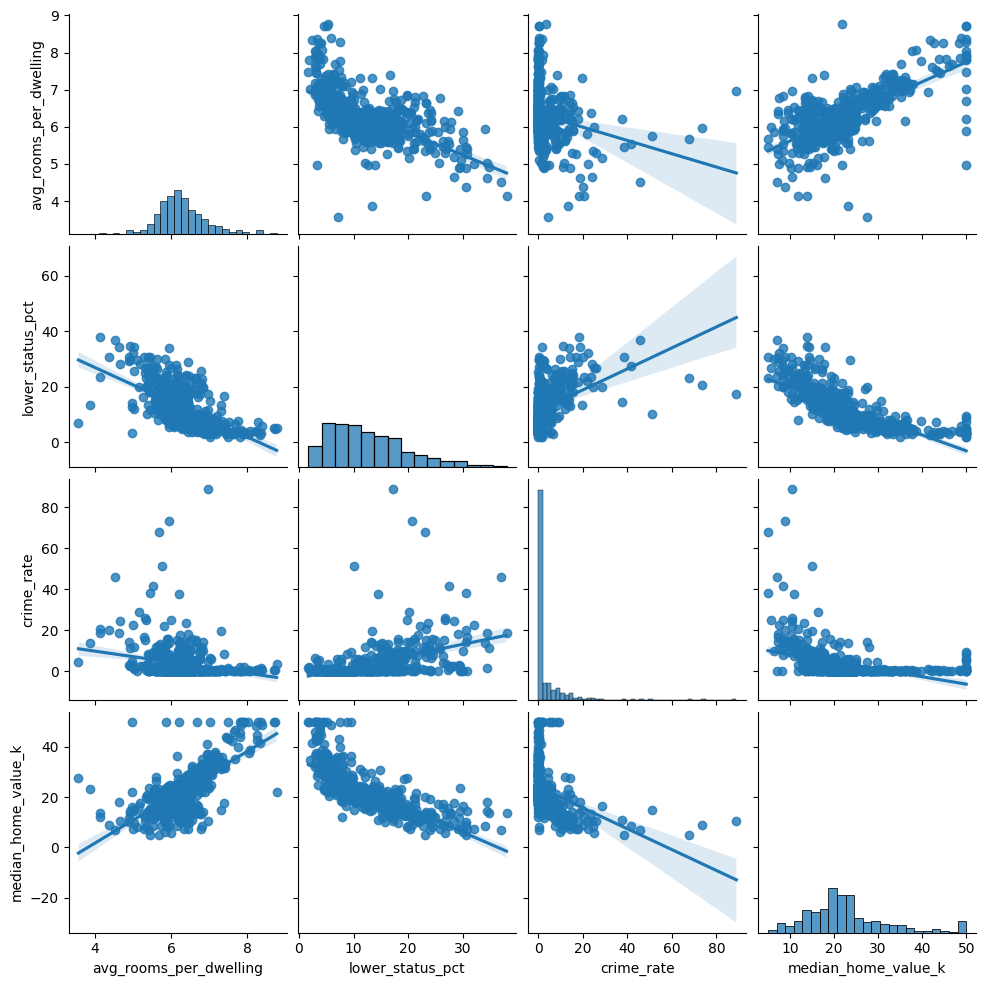

In [21]:
top_features = ['avg_rooms_per_dwelling', 'lower_status_pct', 'crime_rate'] 
sns.pairplot(df, vars=top_features + ['median_home_value_k'], kind='reg')


<Axes: >

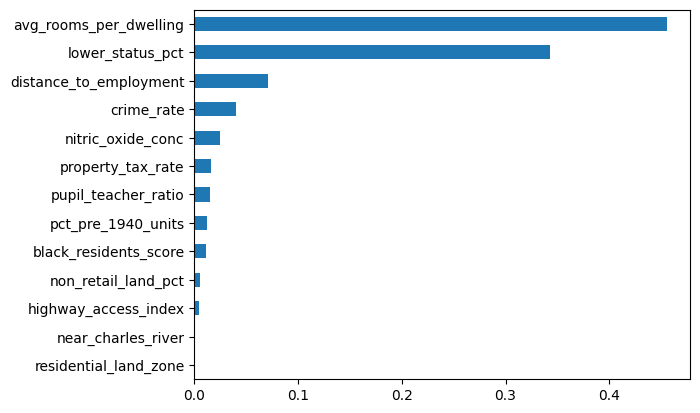

In [22]:
model = RandomForestRegressor()
model.fit(X, y)

importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh')


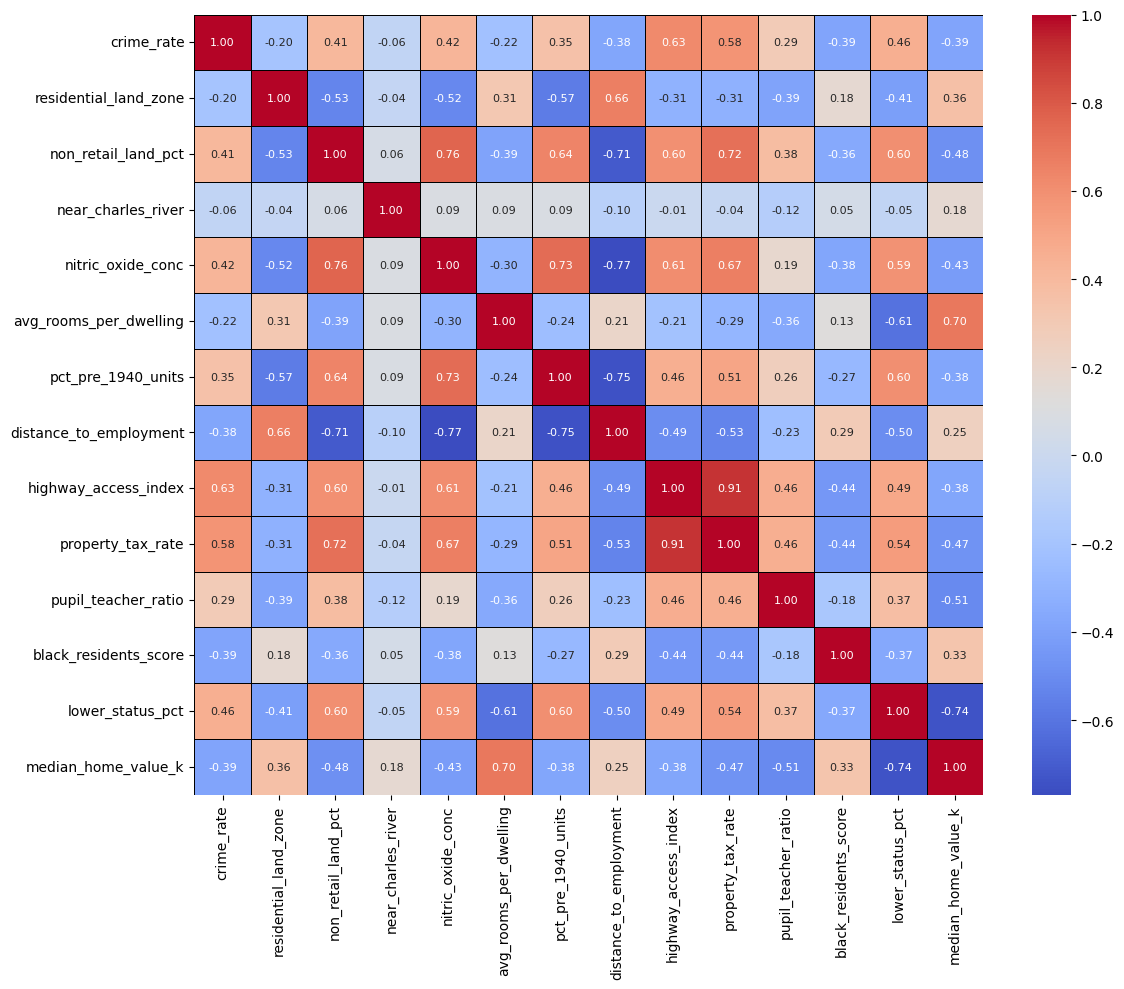

In [23]:
# Set up the figure size before creating the heatmap
plt.figure(figsize=(12, 10))  # Increase the figure size

# Create the heatmap with adjusted parameters
sns.heatmap(df.corr(), 
            annot=True, 
            cmap="coolwarm",
            fmt=".2f",
            linewidths=0.5,
            linecolor='black',
            annot_kws={'size': 8})  # Adjust annotation text size

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()

In [24]:
X = X[selected_features]

### Understanding Feature Relationships

#### Correlation Matrix Analysis
The heatmap above shows the correlation coefficients between all features in our dataset. This visualization helps us:
- Identify which features have strong relationships with our target variable (house prices)
- Detect multicollinearity between features
- Guide feature selection and engineering decisions

Key observations:
1. Strong positive correlations:
   - Average rooms per dwelling (strongest positive correlation with price)
   - Black residents score (indicates potential socio-economic patterns)
2. Strong negative correlations:
   - Lower status percentage (strongest negative correlation)
   - Nitric oxide concentration
3. Multicollinearity concerns:
   - Several features show strong correlations with each other
   - This might affect linear model performance

This correlation analysis guides our feature engineering process and helps us understand potential biases in our dataset.

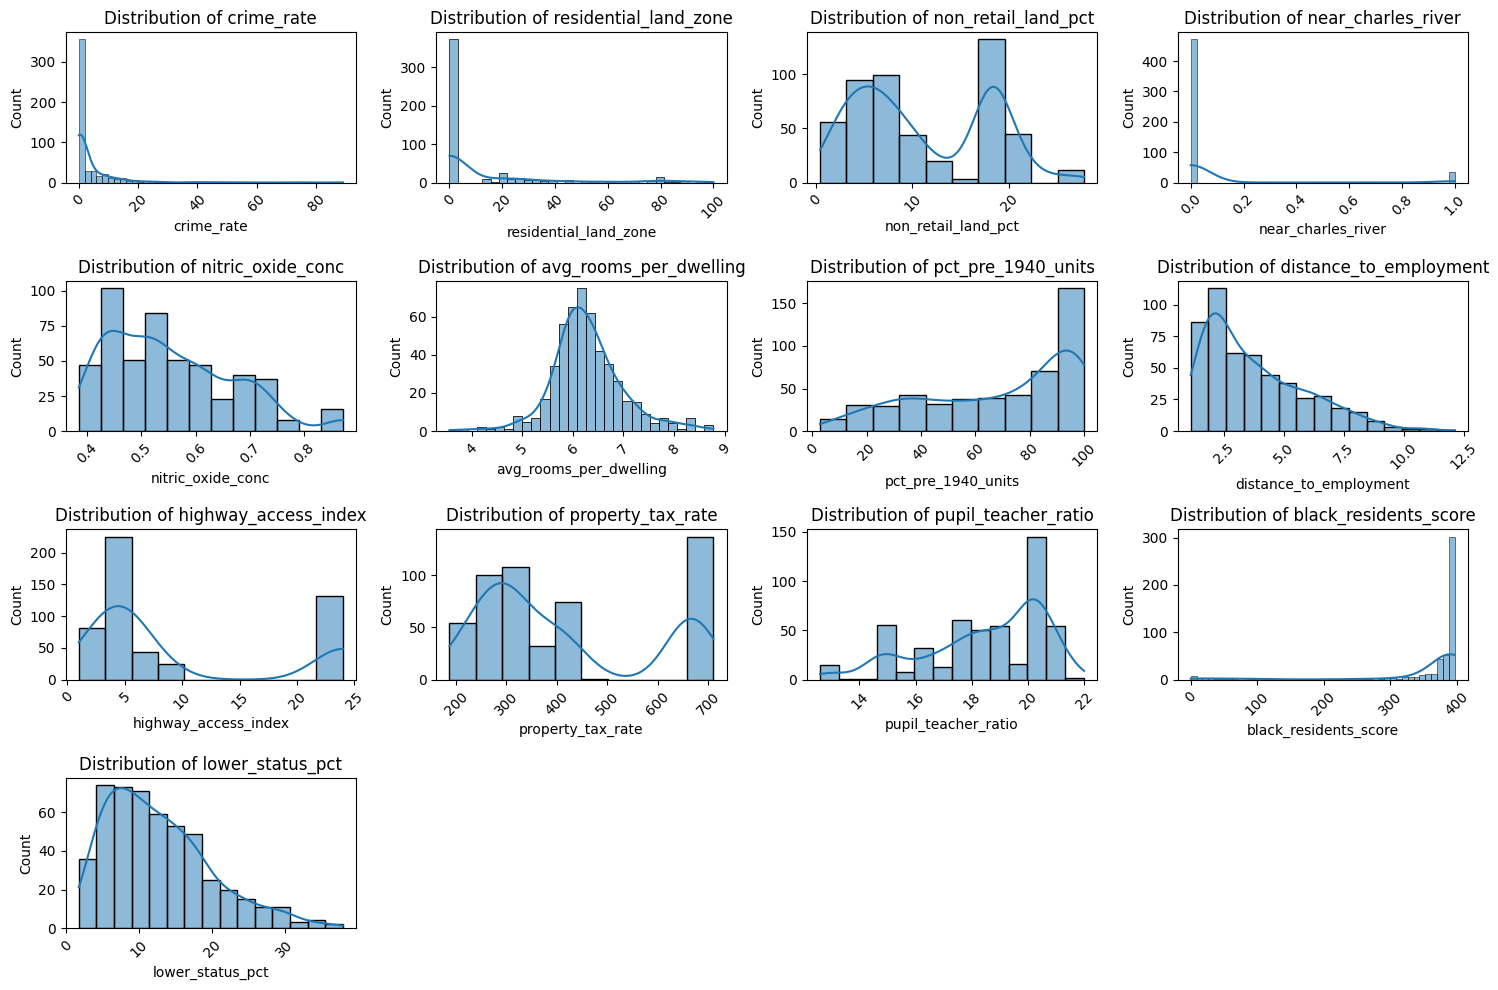

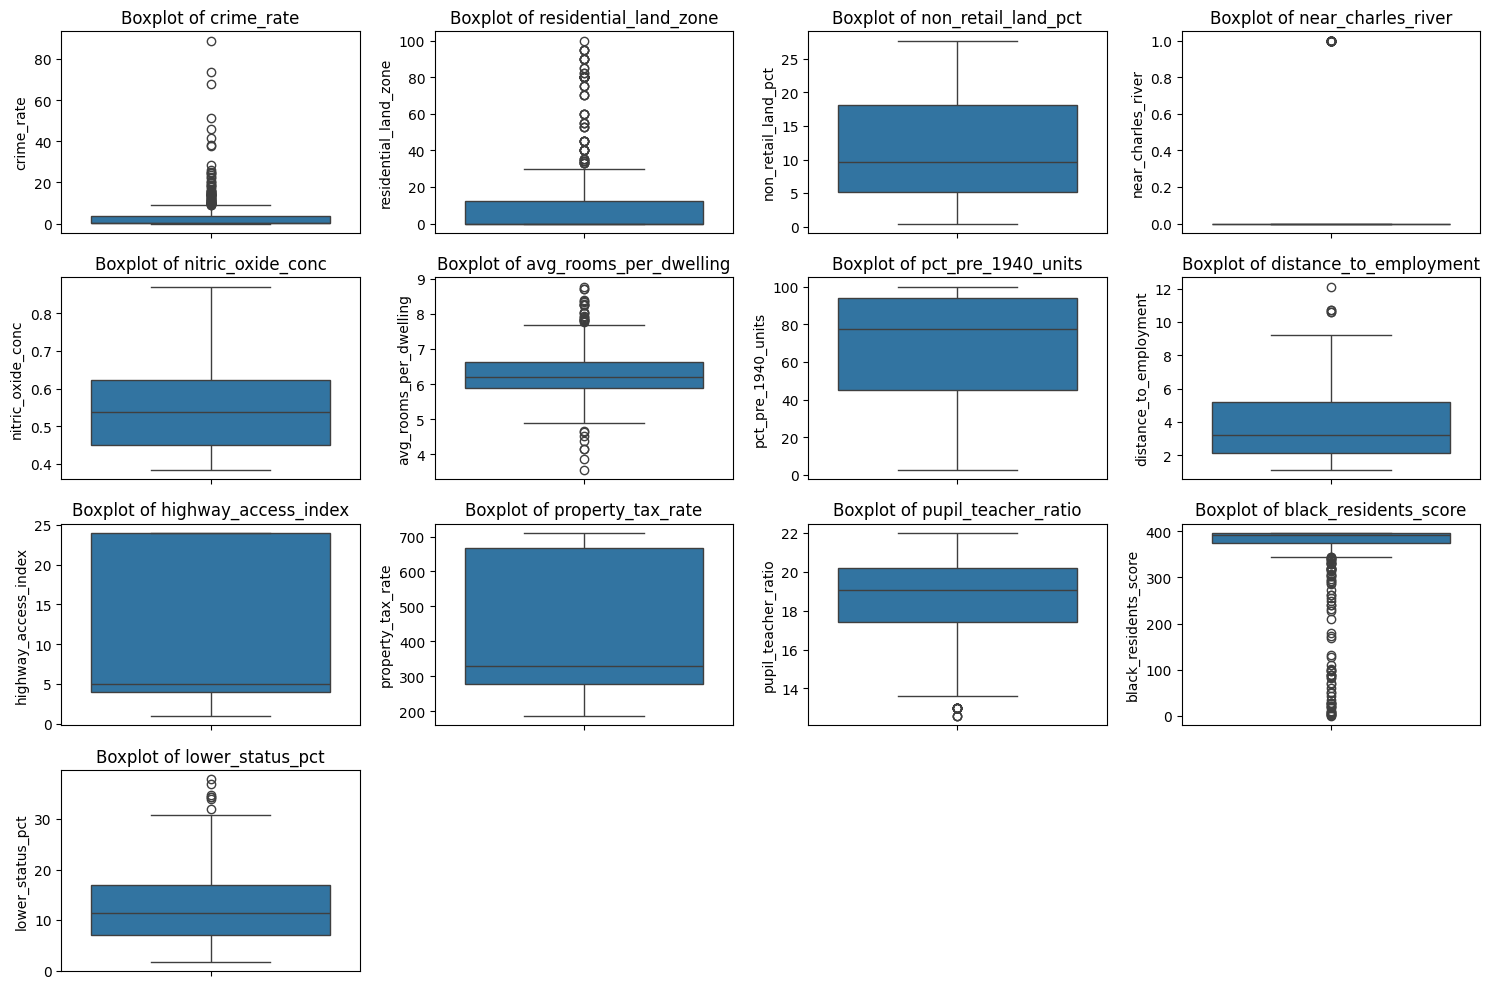

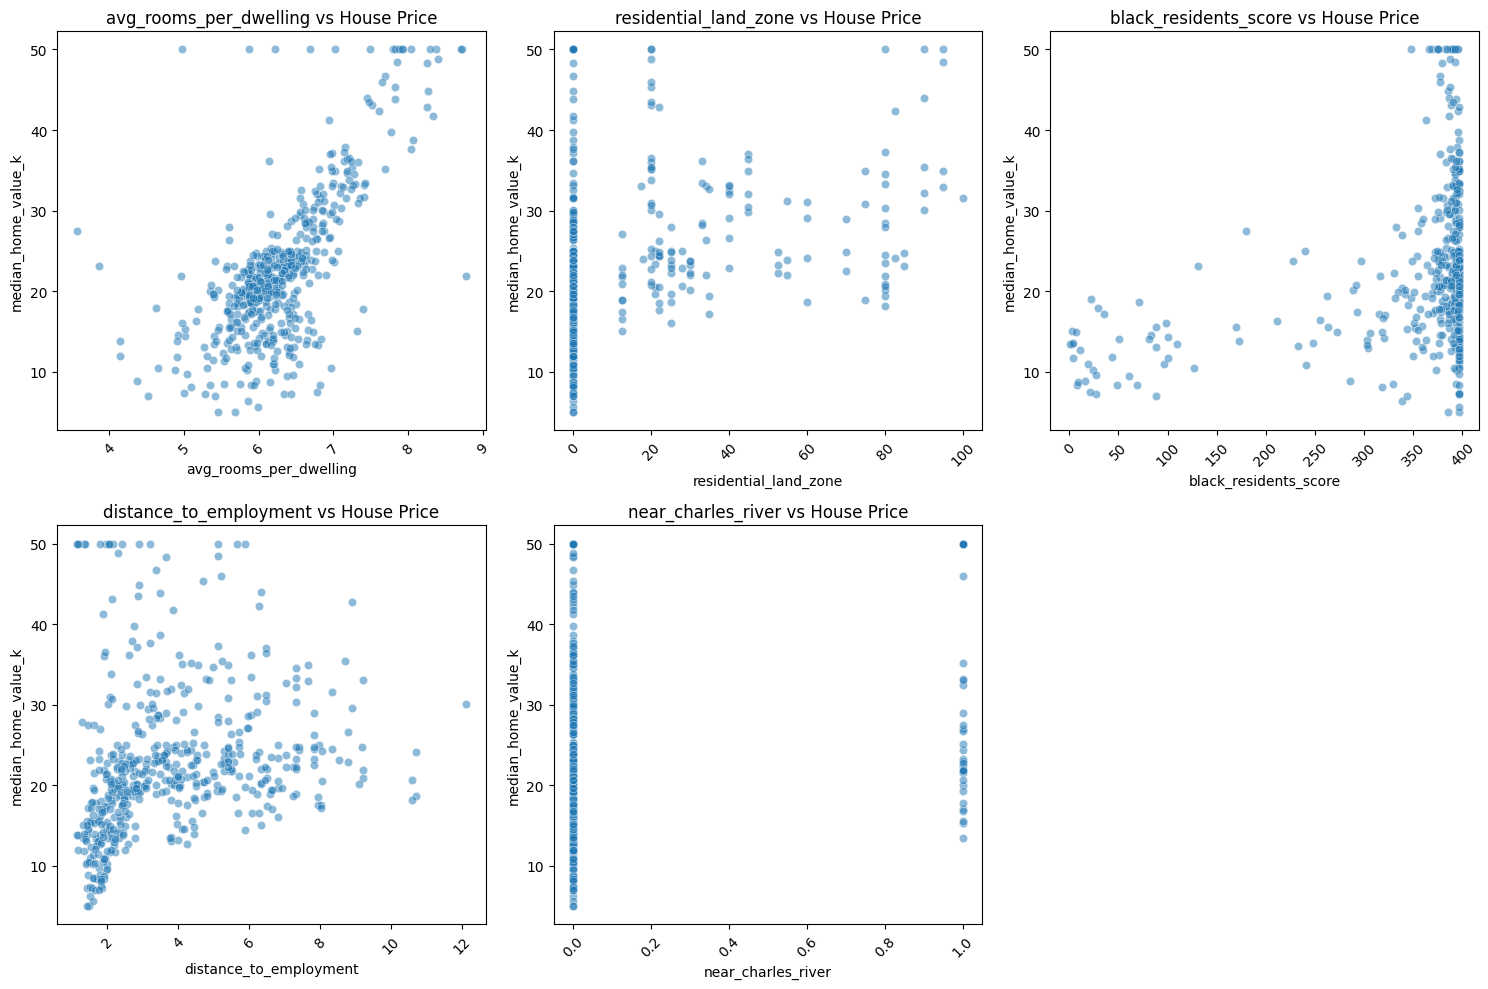


Top 5 Features Correlated with House Price:
median_home_value_k       1.000000
avg_rooms_per_dwelling    0.695360
residential_land_zone     0.360445
black_residents_score     0.333461
distance_to_employment    0.249929
near_charles_river        0.175260
Name: median_home_value_k, dtype: float64


In [25]:
# Distribution plots for numerical features
plt.figure(figsize=(15, 10))
for i, column in enumerate(df.columns[:-1], 1):  # Excluding target variable
    plt.subplot(4, 4, i)
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Box plots to identify outliers
plt.figure(figsize=(15, 10))
for i, column in enumerate(df.columns[:-1], 1):
    plt.subplot(4, 4, i)
    sns.boxplot(y=df[column])
    plt.title(f'Boxplot of {column}')
plt.tight_layout()
plt.show()

# Scatter plots of top correlated features vs target
correlations = df.corr()['median_home_value_k'].sort_values(ascending=False)
top_features = correlations[1:6].index  # Top 5 correlated features

plt.figure(figsize=(15, 10))
for i, feature in enumerate(top_features, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(data=df, x=feature, y='median_home_value_k', alpha=0.5)
    plt.title(f'{feature} vs House Price')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print top correlations
print("\nTop 5 Features Correlated with House Price:")
print(correlations[0:6])

### Distribution and Relationship Analysis

#### Feature Distributions
The distribution plots above show how each feature is distributed in our dataset. This helps us:
- Identify skewed distributions that might need transformation
- Spot potential outliers
- Understand the range and spread of each feature

Key observations:
1. Several features show right-skewed distributions (e.g., crime rate)
2. Some features appear normally distributed
3. The Charles River dummy variable is binary (0/1)

#### Box Plots and Outliers
The box plots reveal:
- The presence of outliers in several features
- The spread and central tendency of each variable
- Features that might benefit from outlier treatment

#### Feature-Target Relationships
The scatter plots show the relationship between our top correlated features and house prices:
1. Some relationships appear linear
2. Others show non-linear patterns
3. Several show heteroscedasticity (varying spread)

These insights inform our modeling choices:
- Need for feature transformations
- Potential for non-linear models
- Importance of robust evaluation metrics

## Exploratory Data Analysis (EDA)

Let's analyze our dataset in detail to understand:
1. Distribution of each variable
2. Relationships between variables
3. Potential outliers
4. Correlation patterns
5. Any patterns that might inform our modeling strategy

In [26]:
# Create interaction terms for highly correlated features
X['rooms_per_dwelling_squared'] = X['avg_rooms_per_dwelling'] ** 2
X['lower_status_squared'] = X['lower_status_pct'] ** 2

# Create distance-based feature
X['dist_to_employment_scaled'] = np.log1p(X['distance_to_employment'])

# Create ratio features
X['price_to_tax_ratio'] = X['property_tax_rate'] / df["median_home_value_k"]
X['crime_to_distance_ratio'] = X['crime_rate'] / X['distance_to_employment']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Feature Engineering and Model Preparation

Based on our EDA insights, we'll:
1. Handle outliers if necessary
2. Create interaction terms for highly correlated features
3. Scale our features
4. Split the data into training and test sets
5. Set up cross-validation

In [27]:
# Scale the features using StandardScaler (often better for regression tasks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name="Model"):
    # Fit the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Cross-validation score
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    
    print(f"\n{model_name} Performance:")
    print(f"R² Score: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"5-Fold CV R² Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    
    # plot actual vs predicted
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5 , colorizer='skyblue')
    plt.xlabel("Actual Prices")
    plt.ylabel("Predicted Prices")
    plt.title(f"Actual vs Predicted Prices ({model_name})")
    plt.show()
    
    
    return model, r2

In [28]:
lasso_cv = LassoCV(alphas=[0.01, 0.1, 0.2 ,0.3 , 0.4 , 0.5 , 10], cv=5)
lasso_cv.fit(X_train, y_train)

print("Best alpha:", lasso_cv.alpha_)

Best alpha: 0.01


c:\Users\mkrym\OneDrive\Desktop\Machine learning\New folder\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.175e+02, tolerance: 2.882e+00
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\mkrym\OneDrive\Desktop\Machine learning\New folder\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.912e+02, tolerance: 2.764e+00
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\mkrym\OneDrive\Desktop\Machine learning\New folder\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase


Linear Regression Performance:
R² Score: 0.8209
MAE: 2.4478
RMSE: 3.6243
5-Fold CV R² Score: 0.8019 (+/- 0.1123)


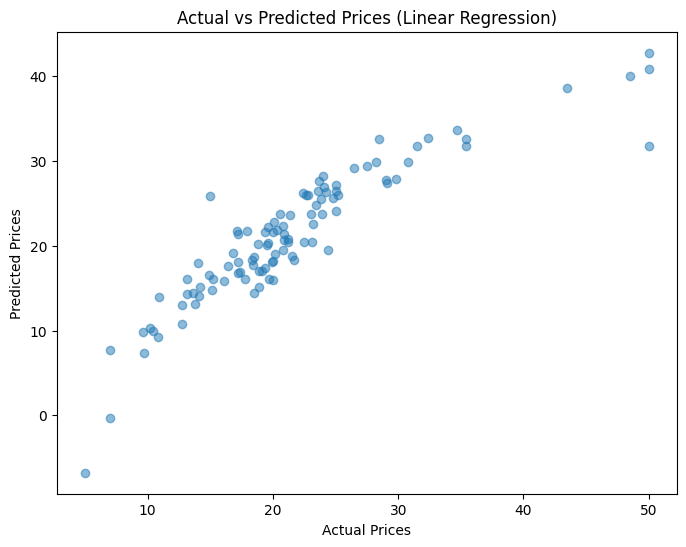


Ridge Performance:
R² Score: 0.8108
MAE: 2.5635
RMSE: 3.7250
5-Fold CV R² Score: 0.8051 (+/- 0.0970)


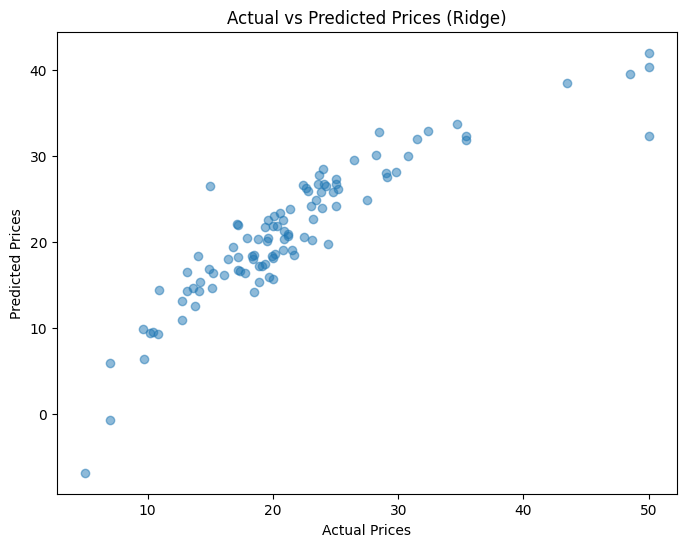


Lasso Performance:
R² Score: 0.7733
MAE: 2.8142
RMSE: 4.0770
5-Fold CV R² Score: 0.7984 (+/- 0.1044)


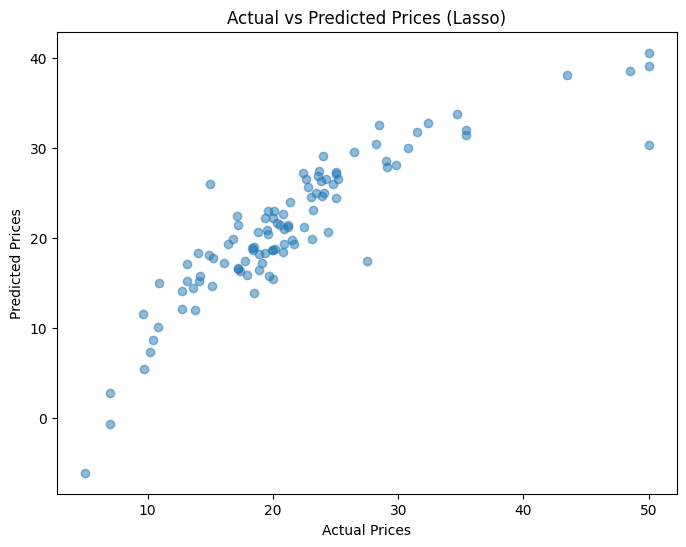


ElasticNet Performance:
R² Score: 0.7264
MAE: 3.0689
RMSE: 4.4791
5-Fold CV R² Score: 0.7775 (+/- 0.1171)


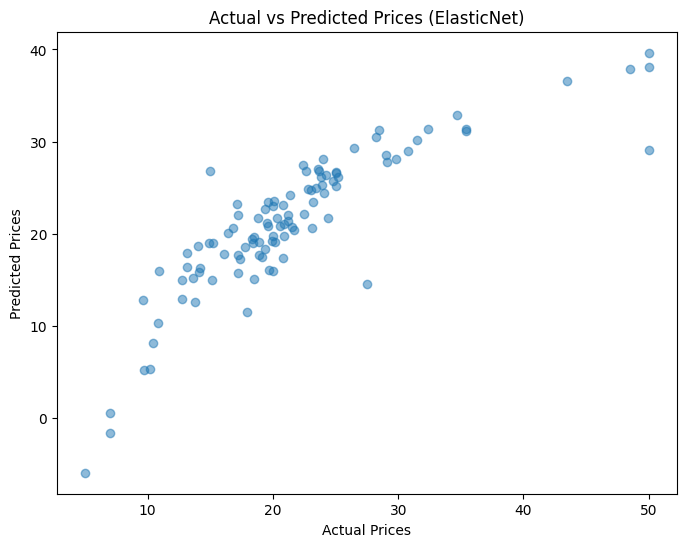


Random Forest Performance:
R² Score: 0.9451
MAE: 1.2008
RMSE: 2.0063
5-Fold CV R² Score: 0.9047 (+/- 0.0648)


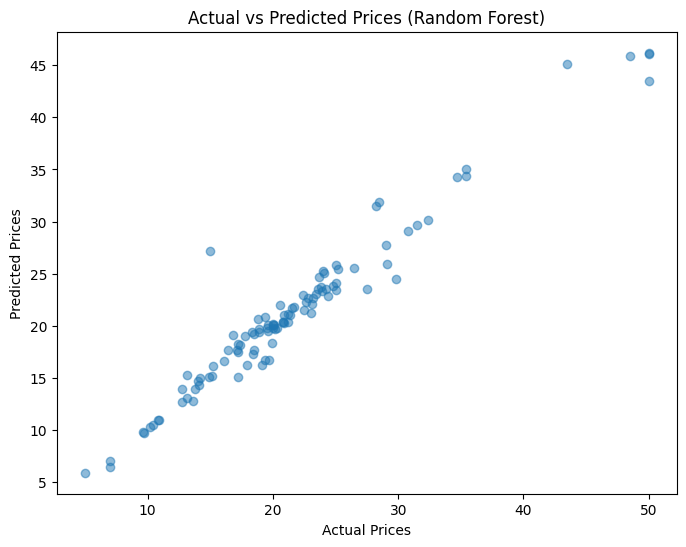


Gradient Boosting Performance:
R² Score: 0.9729
MAE: 1.0338
RMSE: 1.4098
5-Fold CV R² Score: 0.9418 (+/- 0.0369)


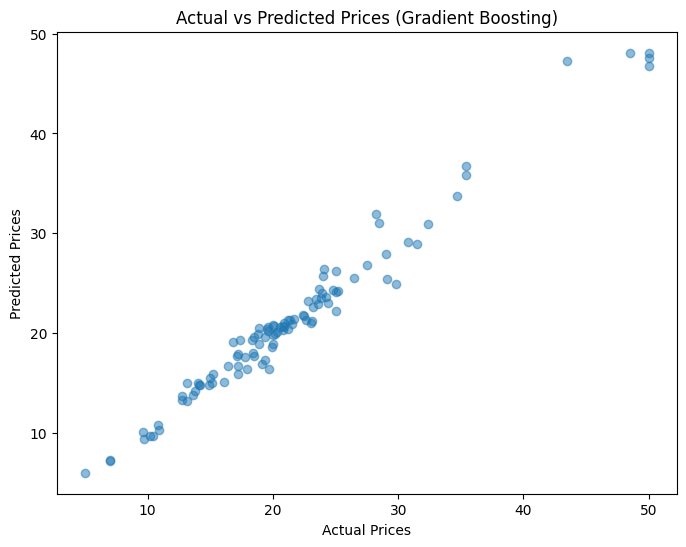


XGBoost Performance:
R² Score: 0.9616
MAE: 1.0301
RMSE: 1.6778
5-Fold CV R² Score: 0.9286 (+/- 0.0527)


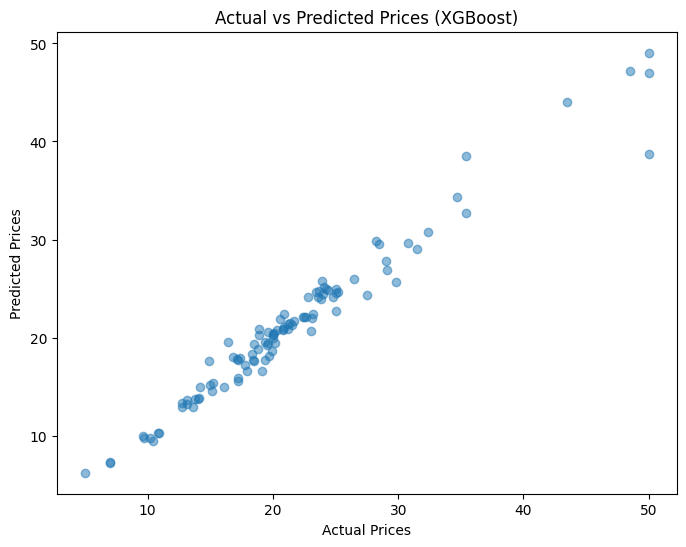

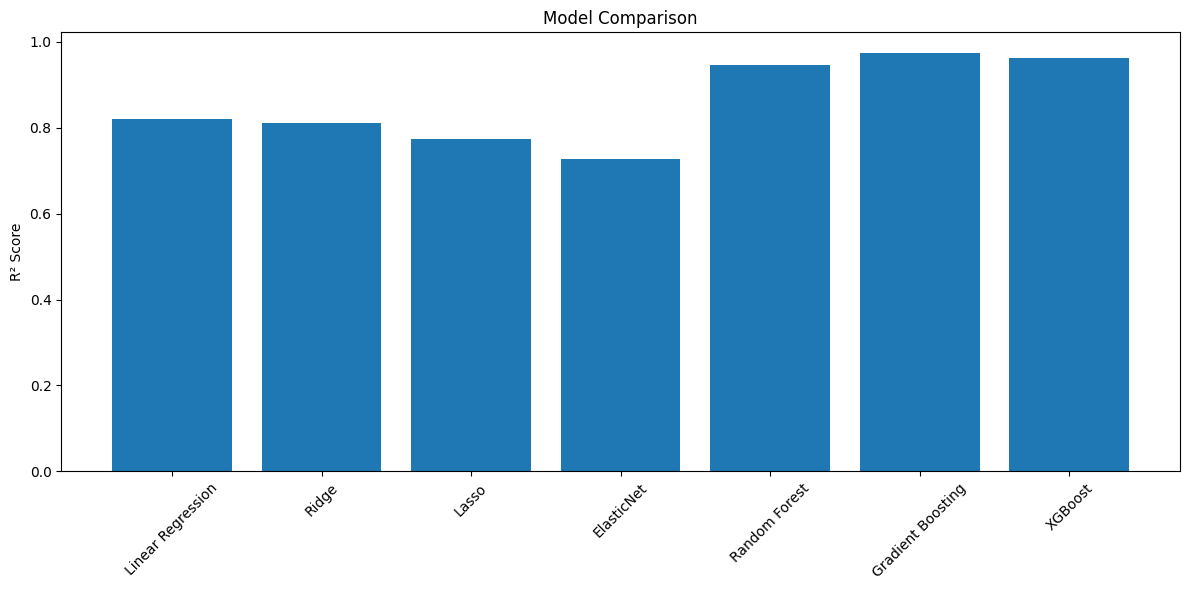


Best performing model: Gradient Boosting


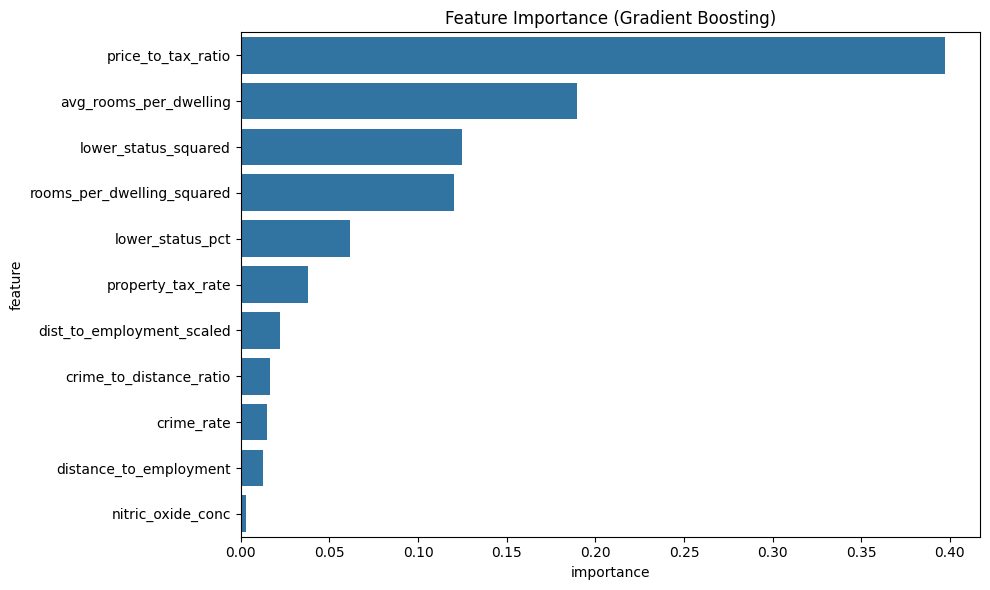

In [29]:
# Create dictionary of models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42)
}

# Dictionary to store results
results = {}

# Evaluate each model
for name, model in models.items():
    model, r2 = evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test, name)
    results[name] = r2

# Plot model comparison
plt.figure(figsize=(12, 6))
plt.bar(results.keys(), results.values())
plt.xticks(rotation=45)
plt.ylabel('R² Score')
plt.title('Model Comparison')
plt.tight_layout()
plt.show()

# Get the best model
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]

print(f"\nBest performing model: {best_model_name}")

# Feature importance for the best model (if it supports feature importance)
if hasattr(best_model, 'feature_importances_'):
    importances = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importances, x='importance', y='feature')
    plt.title(f'Feature Importance ({best_model_name})')
    plt.tight_layout()
    plt.show()

In [30]:
#  save the best model 
joblib.dump(best_model, './models/' + best_model_name + '.pkl')

['./models/Gradient Boosting.pkl']

In [31]:

mlflow.set_experiment("hyperparameter_tuning")


#     'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),

params = {
    'n_estimators' : [100,140,180] , 
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [ 0.01 , 0.05, 0.1, 0.2, 0.3, 0.4, 0.5 ],
}

model = GradientBoostingRegressor()

with mlflow.start_run(run_name = 'hypertuning_paramtter'):
    
    mlflow.log_params(params)
    
    # perform grid search for hyperparameter tuning 
    grid_search = GridSearchCV(model, params, cv=5 , scoring='r2', verbose=1)
    
    grid_search.fit(X_train_scaled, y_train)
    
    best_model = grid_search.best_estimator_
    test_accuracy = grid_search.score(X_test_scaled, y_test)
    best_score = grid_search.best_score_
    
    # log params
    mlflow.log_param('search_type' , 'grid_search')
    mlflow.log_param("cv_folds", 5)
    mlflow.log_param('best_params', grid_search.best_params_)
    
    #  log matrics
    mlflow.log_metric("best_cv_score", best_score)
    mlflow.log_metric("best_test_score", test_accuracy)
    
    # log the best model
    mlflow.sklearn.log_model(grid_search.best_estimator_, "best_model" , registered_model_name="best_gradient_boosting_model")
    
    # save the best model 
    joblib.dump(grid_search.best_estimator_, './models/best_gradient_boosting_model.pkl')
    mlflow.log_artifact('./models/best_gradient_boosting_model.pkl' , artifact_path="models")
    
    print("Model logged to MLflow")

Fitting 5 folds for each of 84 candidates, totalling 420 fits


2025/07/21 10:31:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/21 10:31:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'best_gradient_boosting_model' already exists. Creating a new version of this model...
2025/07/21 10:31:36 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: best_gradient_boosting_model, version 2
Created version '2' of model 'best_gradient_boosting_model'.


Model logged to MLflow
🏃 View run hypertuning_paramtter at: http://localhost:5000/#/experiments/393191089952120864/runs/2d2dca557d454a1e8c350be26cf11a78
🧪 View experiment at: http://localhost:5000/#/experiments/393191089952120864
